## VAE MNIST example: BO in a latent space

In this tutorial, we use the MNIST dataset and some standard PyTorch examples to show a synthetic problem where the input to the objective function is a `28 x 28` image. The main idea is to train a [variational auto-encoder (VAE)](https://arxiv.org/abs/1312.6114) on the MNIST dataset and run Bayesian Optimization in the latent space. We also refer readers to [this tutorial](http://krasserm.github.io/2018/04/07/latent-space-optimization/), which discusses [the method](https://arxiv.org/abs/1610.02415) of jointly training a VAE with a predictor (e.g., classifier), and shows a similar tutorial for the MNIST setting.

In [1]:
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets # transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("CI", "false") == "true"

### Problem setup

Let's first define our synthetic expensive-to-evaluate objective function. We assume that it takes the following form:

$$\text{image} \longrightarrow \text{image classifier} \longrightarrow \text{scoring function} 
\longrightarrow \text{score}.$$

The classifier is a convolutional neural network (CNN) trained using the architecture of the [PyTorch CNN example](https://github.com/pytorch/examples/tree/master/mnist).

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

We next instantiate the CNN for digit recognition and load a pre-trained model.

Here, you may have to change `PRETRAINED_LOCATION` to the location of the `pretrained_models` folder on your machine.

In [3]:
PRETRAINED_LOCATION = "./pretrained_models"

cnn_model = Net().to(dtype=dtype, device=device)
cnn_state_dict = torch.load(os.path.join(PRETRAINED_LOCATION, "mnist_cnn.pt"), map_location=device)
cnn_model.load_state_dict(cnn_state_dict);

Our VAE model follows the [PyTorch VAE example](https://github.com/pytorch/examples/tree/master/vae), except that we use the same data transform from the CNN tutorial for consistency. We then instantiate the model and again load a pre-trained model. To train these models, we refer readers to the PyTorch Github repository. 

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    
vae_model = VAE().to(dtype=dtype, device=device)
vae_state_dict = torch.load(os.path.join(PRETRAINED_LOCATION, "mnist_vae.pt"), map_location=device)
vae_model.load_state_dict(vae_state_dict);

We now define the scoring function that maps digits to scores. The function below prefers the digit '3'.

In [5]:
def score(y):
    """Returns a 'score' for each digit from 0 to 9. It is modeled as a squared exponential
    centered at the digit '3'.
    """
    return torch.exp(-2 * (y - 3)**2)

Given the scoring function, we can now write our overall objective, which as discussed above, starts with an image and outputs a score. Let's say the objective computes the expected score given the probabilities from the classifier.

In [6]:
def score_image_recognition(x):
    """The input x is an image and an expected score based on the CNN classifier and
    the scoring function is returned.
    """
    with torch.no_grad():
        probs = torch.exp(cnn_model(x))  # b x 10
        scores = score(torch.arange(10, device=device, dtype=dtype)).expand(probs.shape)
    return (probs * scores).sum(dim=1)

Finally, we define a helper function `decode` that takes as input the parameters `mu` and `logvar` of the variational distribution and performs reparameterization and the decoding. We use batched Bayesian optimization to search over the parameters `mu` and `logvar`

In [7]:
def decode(train_x):
    with torch.no_grad():
        decoded = vae_model.decode(train_x)
    return decoded.view(train_x.shape[0], 1, 28, 28)

#### Model initialization and initial random batch

We use a `SingleTaskGP` to model the score of an image generated by a latent representation. The model is initialized with points drawn from $[-6, 6]^{20}$.

In [8]:
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize

d = 20
bounds = torch.tensor([[-6.0] * d, [6.0] * d], device=device, dtype=dtype)


def gen_initial_data(n=5):
    # generate training data  
    train_x = unnormalize(torch.rand(n, d, device=device, dtype=dtype), bounds=bounds)
    train_obj = score_image_recognition(decode(train_x)).unsqueeze(-1)  # add output dimension
    best_observed_value = train_obj.max().item()
    return train_x, train_obj, best_observed_value


def get_fitted_model(train_x, train_obj, state_dict=None):
    # initialize and fit model
    model = SingleTaskGP(train_X=train_x, train_Y=train_obj)
    if state_dict is not None:
        model.load_state_dict(state_dict)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    fit_gpytorch_model(mll)
    return model

#### Define a helper function that performs the essential BO step
The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. For this example, we'll use a small batch of $q=3$.

In [9]:
from botorch.optim import optimize_acqf


BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 256 if not SMOKE_TEST else 4


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.stack([
            torch.zeros(d, dtype=dtype, device=device), 
            torch.ones(d, dtype=dtype, device=device),
        ]),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # observe new values 
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = score_image_recognition(decode(new_x)).unsqueeze(-1)  # add output dimension
    return new_x, new_obj

### Perform Bayesian Optimization loop with qEI
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps: (1) given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$, (2) observe $f(x)$ for each $x$ in the batch, and (3) update the surrogate model. We run `N_BATCH=75` iterations. The acquisition function is approximated using `MC_SAMPLES=2048` samples. We also initialize the model with 5 randomly drawn points.

In [10]:
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler

seed=1
torch.manual_seed(seed)

N_BATCH = 50 if not SMOKE_TEST else 3
MC_SAMPLES = 2048 if not SMOKE_TEST else 32
best_observed = []

# call helper function to initialize model
train_x, train_obj, best_value = gen_initial_data(n=5)
best_observed.append(best_value)

We are now ready to run the BO loop (this make take a few minutes, depending on your machine).

In [11]:
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")


print(f"\nRunning BO ", end='')

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(N_BATCH):    

    # fit the model
    model = get_fitted_model(
        normalize(train_x, bounds=bounds), 
        standardize(train_obj), 
        state_dict=state_dict,
    )
    
    # define the qNEI acquisition module using a QMC sampler
    qmc_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES, seed=seed)
    qEI = qExpectedImprovement(model=model, sampler=qmc_sampler, best_f=standardize(train_obj).max())

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qEI)

    # update training points
    train_x = torch.cat((train_x, new_x))
    train_obj = torch.cat((train_obj, new_obj))

    # update progress
    best_value = train_obj.max().item()
    best_observed.append(best_value)
    
    state_dict = model.state_dict()
    
    print(".", end='')


Running BO ..................................................

EI recommends the best point observed so far. We can visualize what the images corresponding to recommended points *would have* been if the BO process ended at various times. Here, we show the progress of the algorithm by examining the images at 0%, 10%, 25%, 50%, 75%, and 100% completion. The first image is the best image found through the initial random batch.

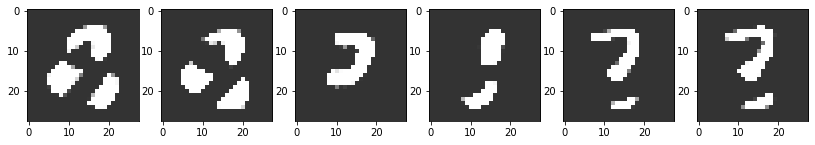

In [12]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(1, 6, figsize=(14, 14))
percentages = np.array([0, 10, 25, 50, 75, 100], dtype=np.float32)
inds = (N_BATCH * BATCH_SIZE * percentages / 100 + 4).astype(int)

for i, ax in enumerate(ax.flat):
    b = torch.argmax(score_image_recognition(decode(train_x[:inds[i],:])), dim=0)
    img = decode(train_x[b].view(1, -1)).squeeze().cpu()
    ax.imshow(img, alpha=0.8, cmap='gray')